In [2]:
# Module with plot capabilities
import matplotlib.pyplot as plt
import seaborn as sns
import hyperspy.api as hs

# Module with scientific computing functions (matrix/vector)
import numpy as np                

# Modules with reading/write folder/file functions
import os
from pathlib import Path
import SimpleITK as sitk

# module to deal with images
import uproot
#%pip install SciencePlots
import scienceplots
plt.style.use(['science', 'ieee'])  

# The following command display the current working directory (where jupyter has been launched)
cwd = os.getcwd()
print('The Current Working Directory (CWD) is: \n', cwd)
folder = Path()

# Display the content of a folder
output_folder = Path('./output')
if not output_folder.is_dir():
    print('ERROR: {} is not a folder.'.format(output_folder))
else:
    print('The folder and contains the following files:'.format(output_folder))
    p = output_folder.glob('**/*')
    files = [x for x in p if x.is_file()]
    for x in files:
        print(x)

The Current Working Directory (CWD) is: 
 /home/francesco/gate/VHEE_monitor
The folder and contains the following files:
output/c11data.root
output/c11hits.root
output/stats.txt


In [3]:
f = uproot.open('o15/o15hits.root')
print("List of tree : \n", f.keys())
hits = f['Singles']
print('Number of hits:', hits.num_entries)
print('Hits keys: ')
for i in hits.keys():
    print(i, ' ', end='')

List of tree : 
 ['Singles;1']
Number of hits: 6154.0
Hits keys: 
PostPosition_X  PostPosition_Y  PostPosition_Z  PreKineticEnergy  TotalEnergyDeposit  PreDirection_X  PreDirection_Y  PreDirection_Z  PreStepUniqueVolumeID  GlobalTime  

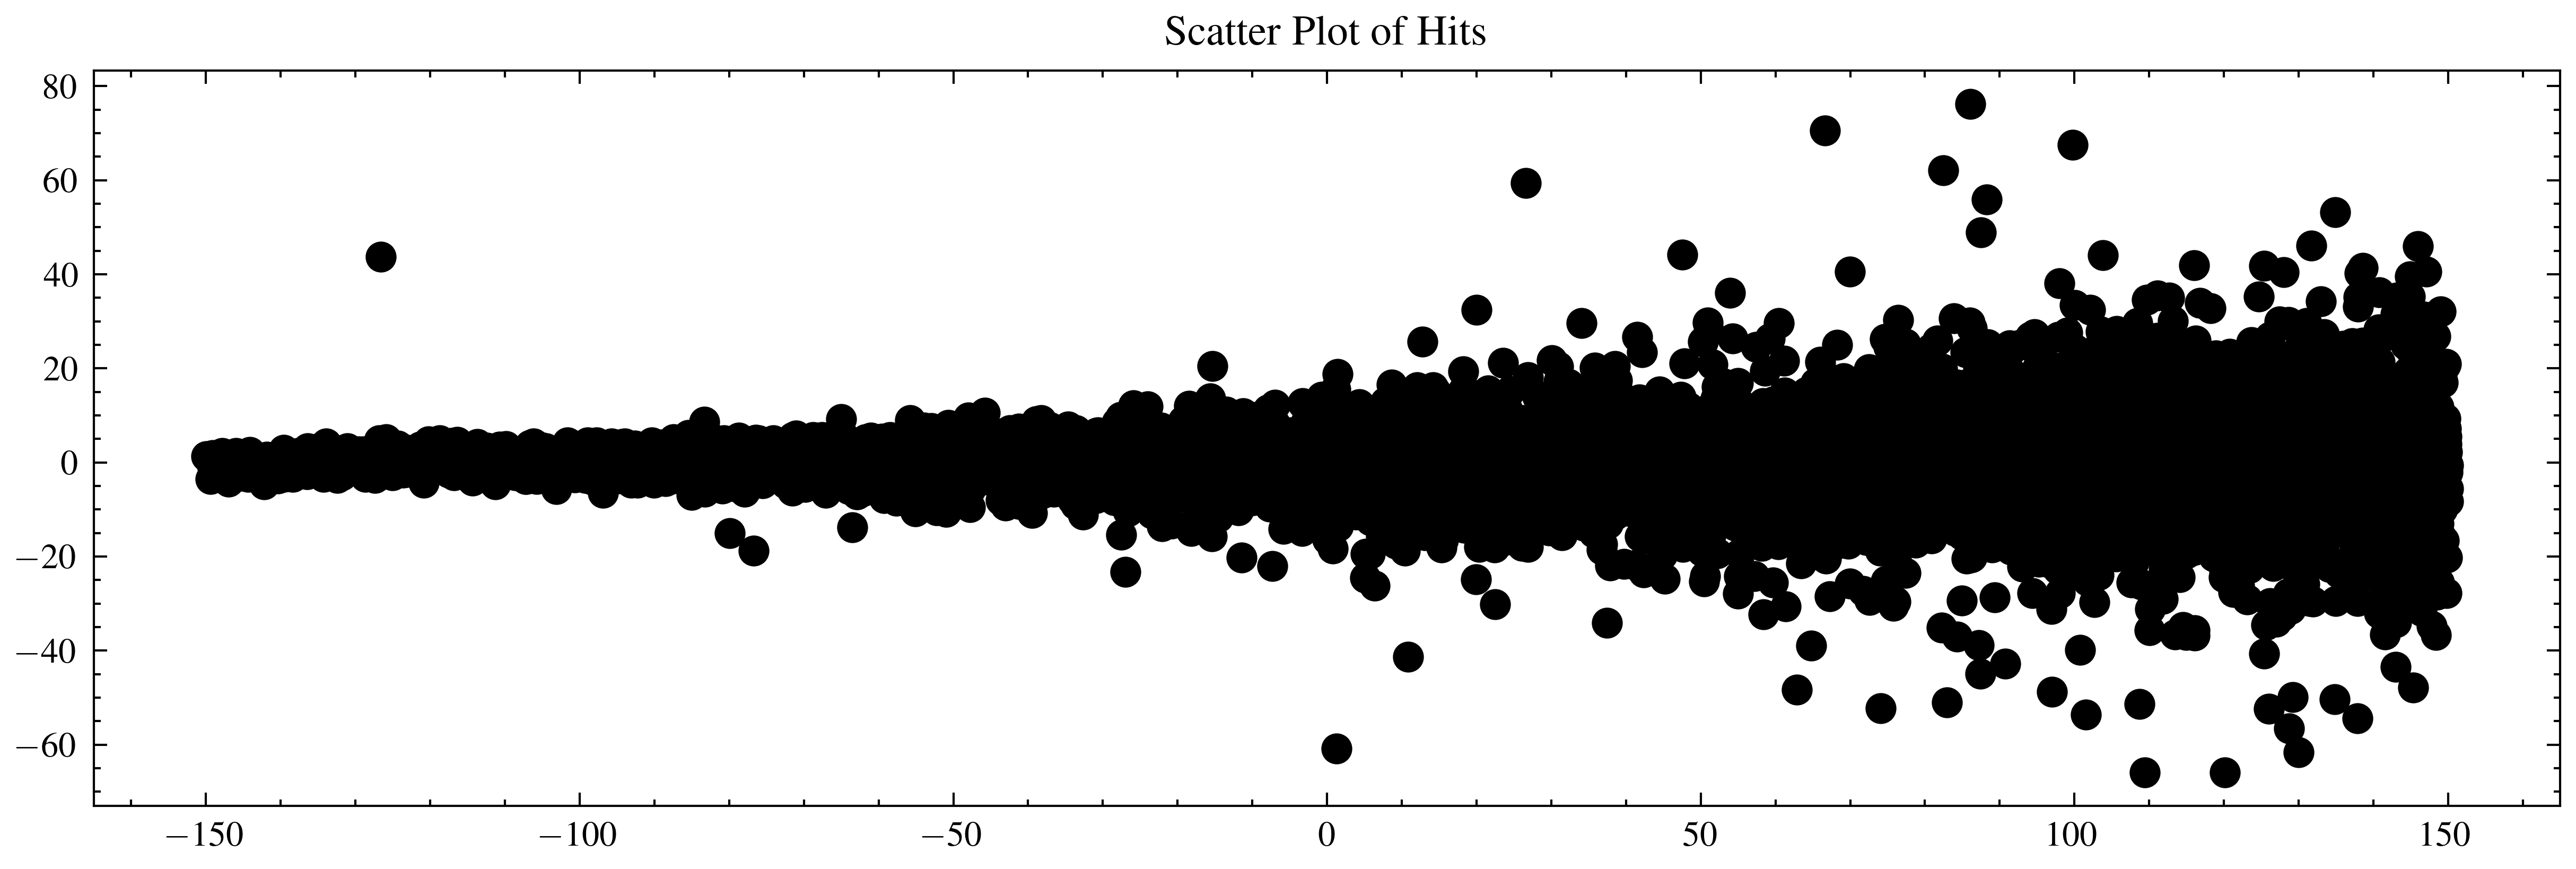

In [4]:
hits_y = np.array(hits.arrays()['PostPosition_Y'])
hits_z = np.array(hits.arrays()['PostPosition_Z'])
hits_x = np.array(hits.arrays()['PostPosition_X'])
preKinEnergy = np.array(hits.arrays()['PreKineticEnergy'])  

preKinEnergy_enwin = np.logical_and(preKinEnergy > 0, preKinEnergy < 2)

masky=np.logical_and(hits_y > -3, hits_y < 3)
hits_y_enwin = hits_y[preKinEnergy_enwin]
hits_z_enwin = hits_z[preKinEnergy_enwin]


plt.figure(figsize=(10, 3))

plt.scatter(x=hits_z, y=hits_y)

plt.title('Scatter Plot of Hits')
plt.show()







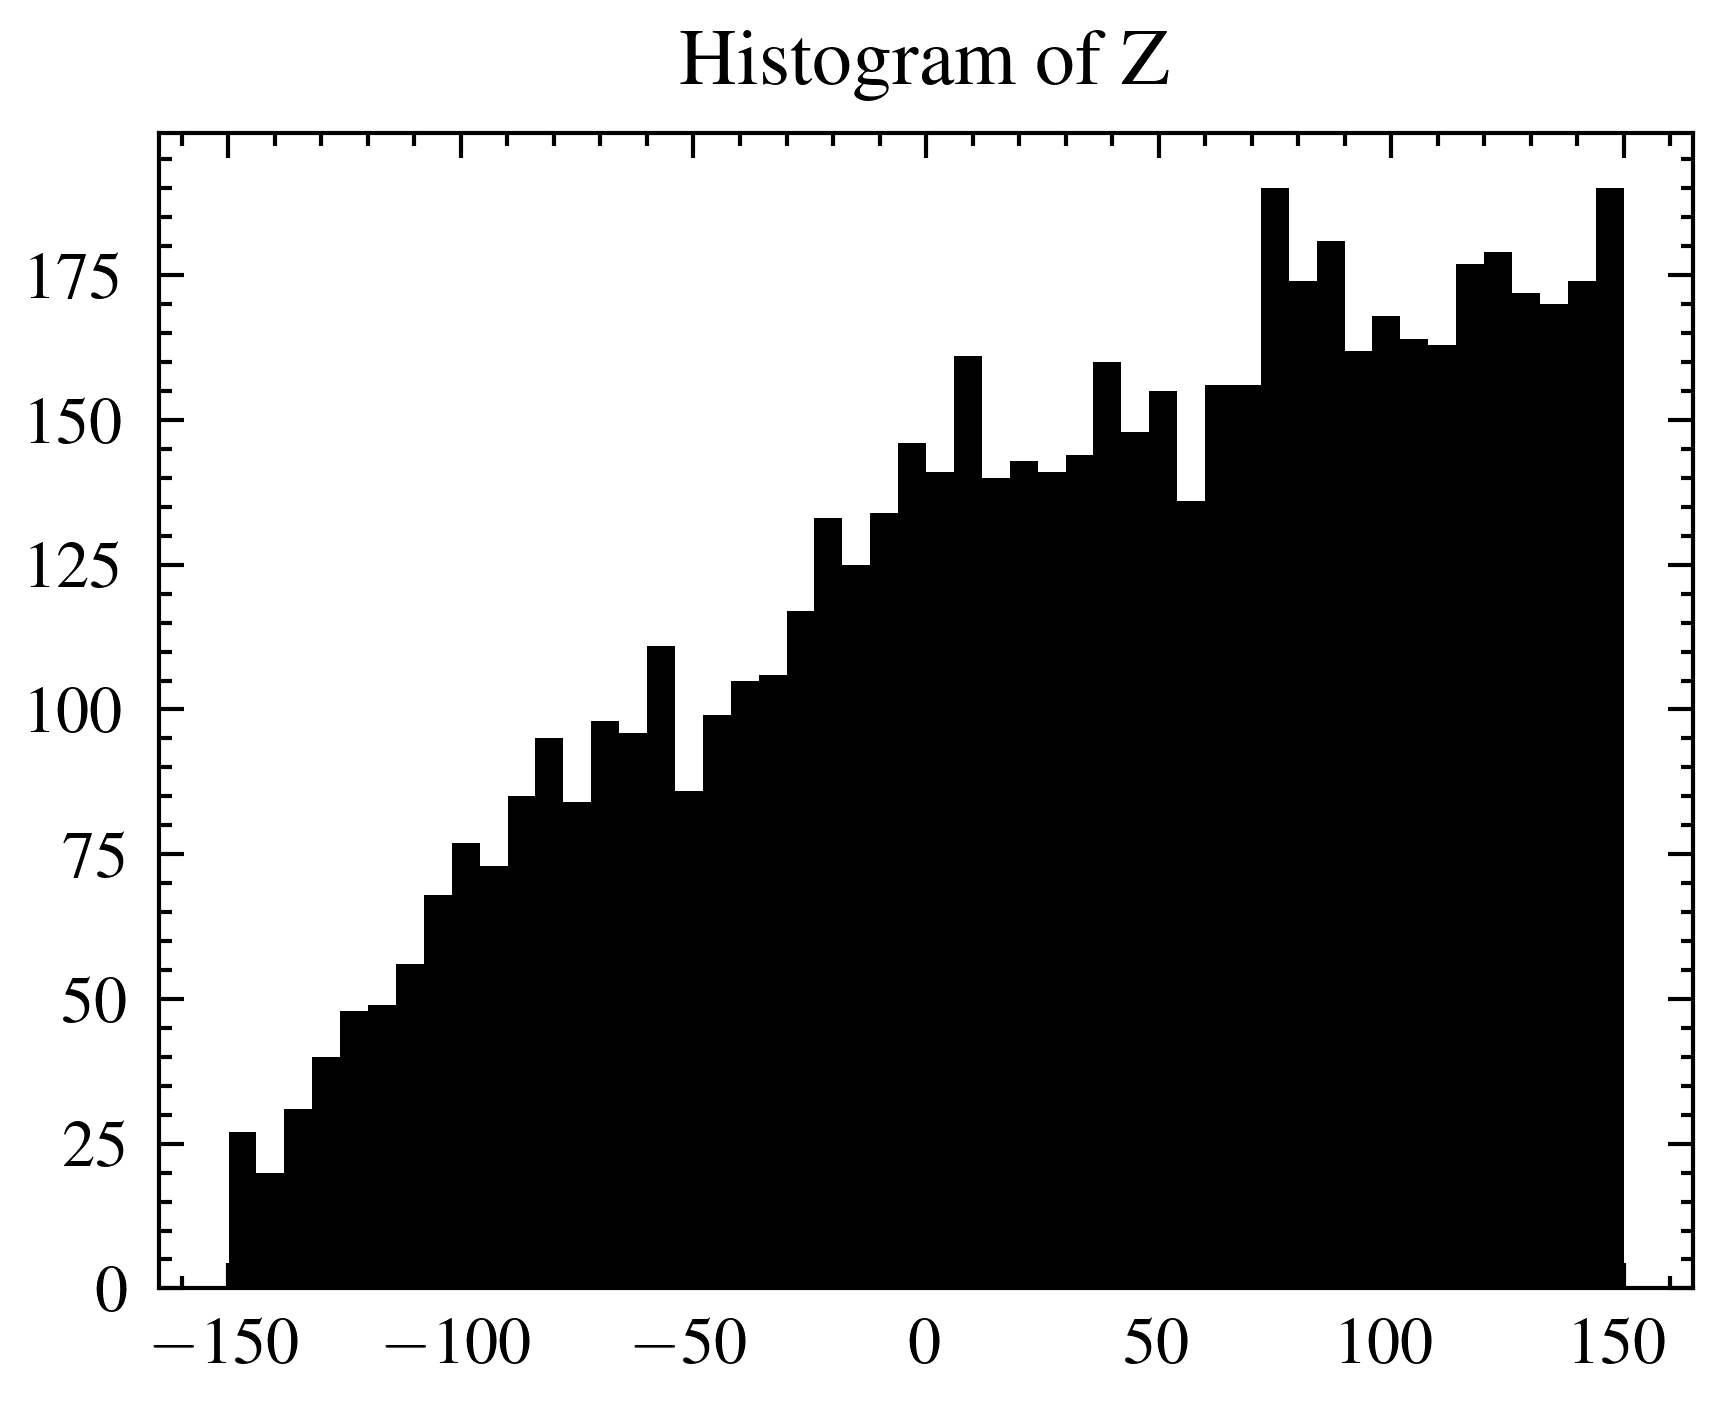

In [5]:
plt.hist(hits_z, bins=50)
plt.title('Histogram of Z')
plt.show()



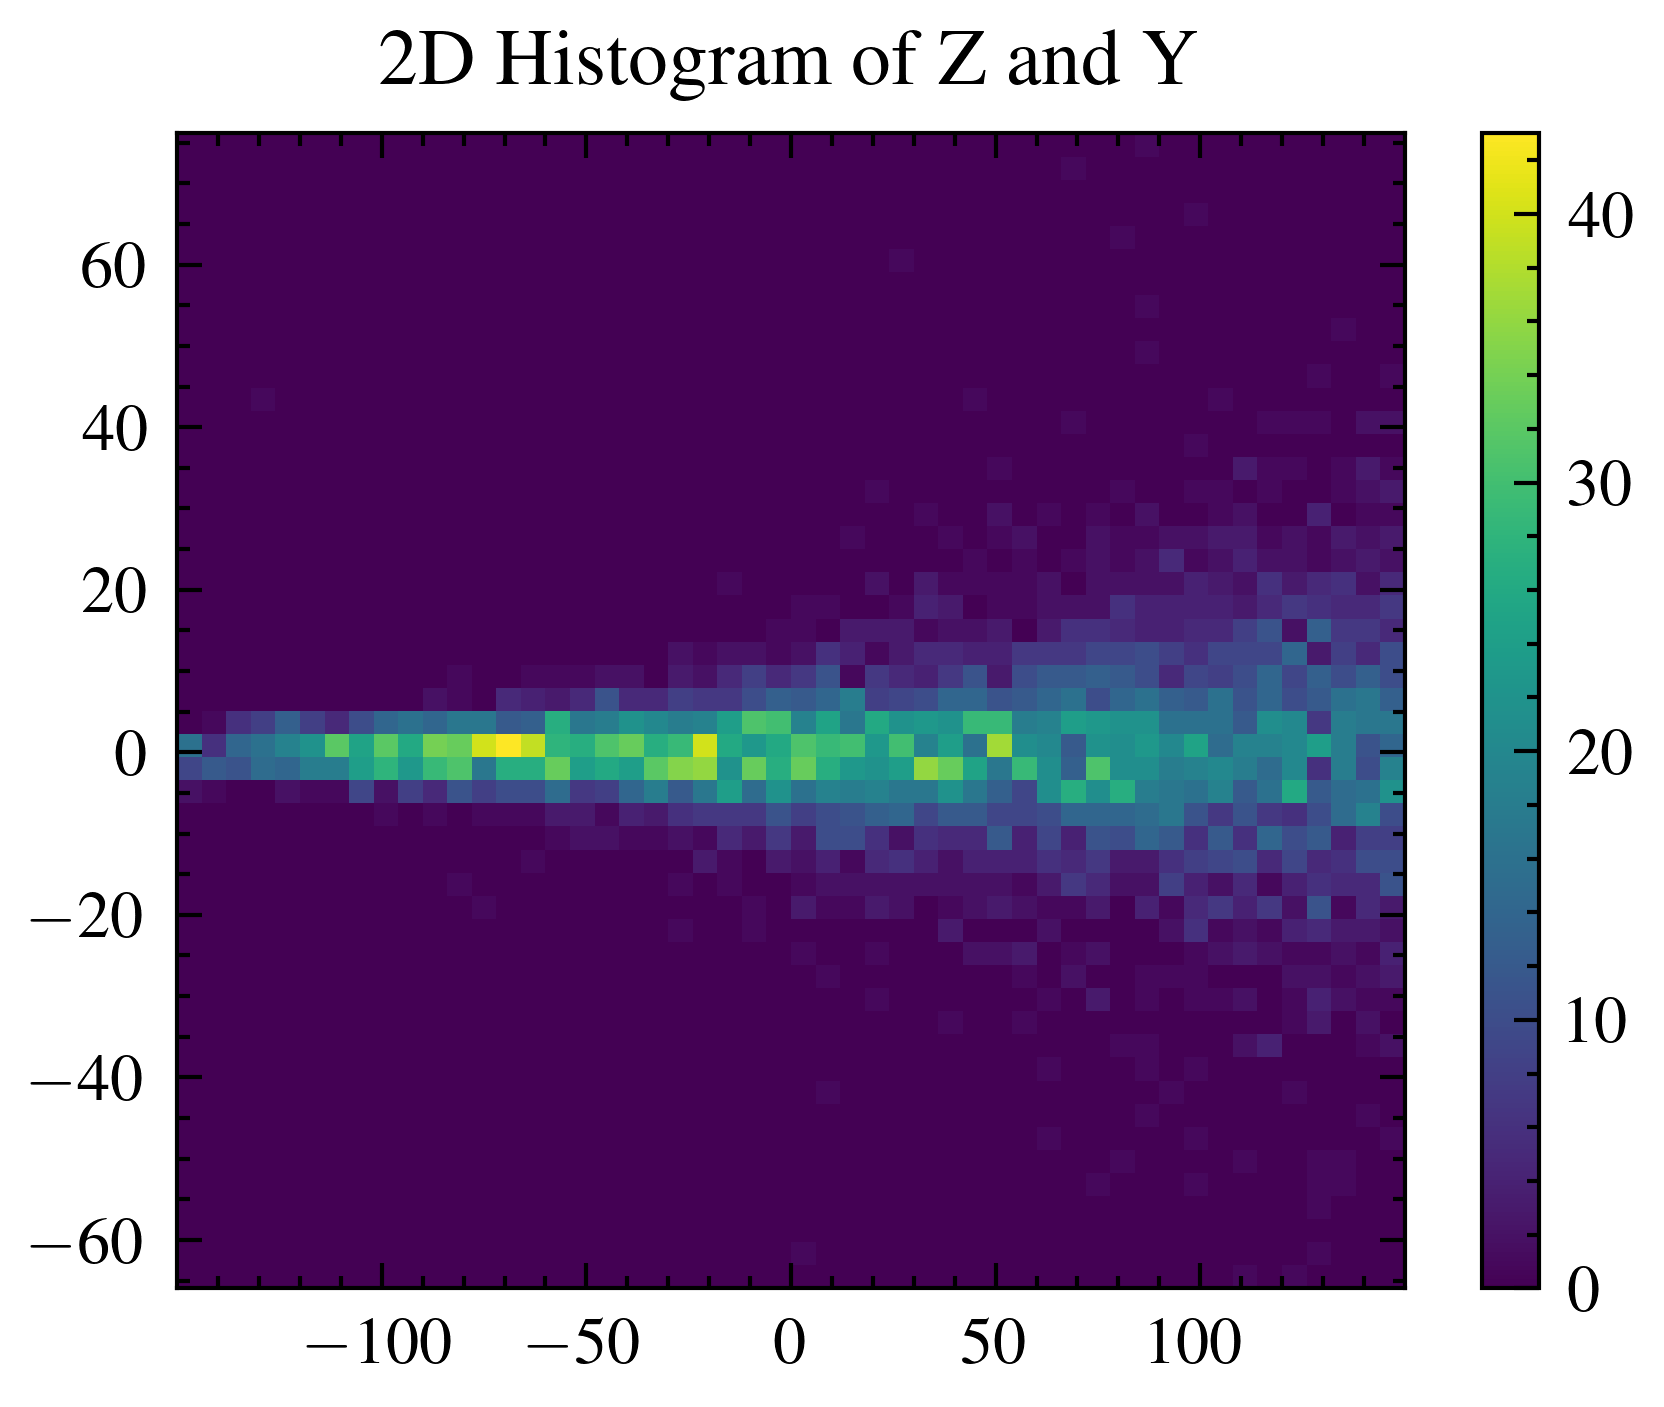

In [6]:
plt.hist2d(hits_z, hits_y, bins=50) 
plt.colorbar()
plt.title('2D Histogram of Z and Y')
plt.show()


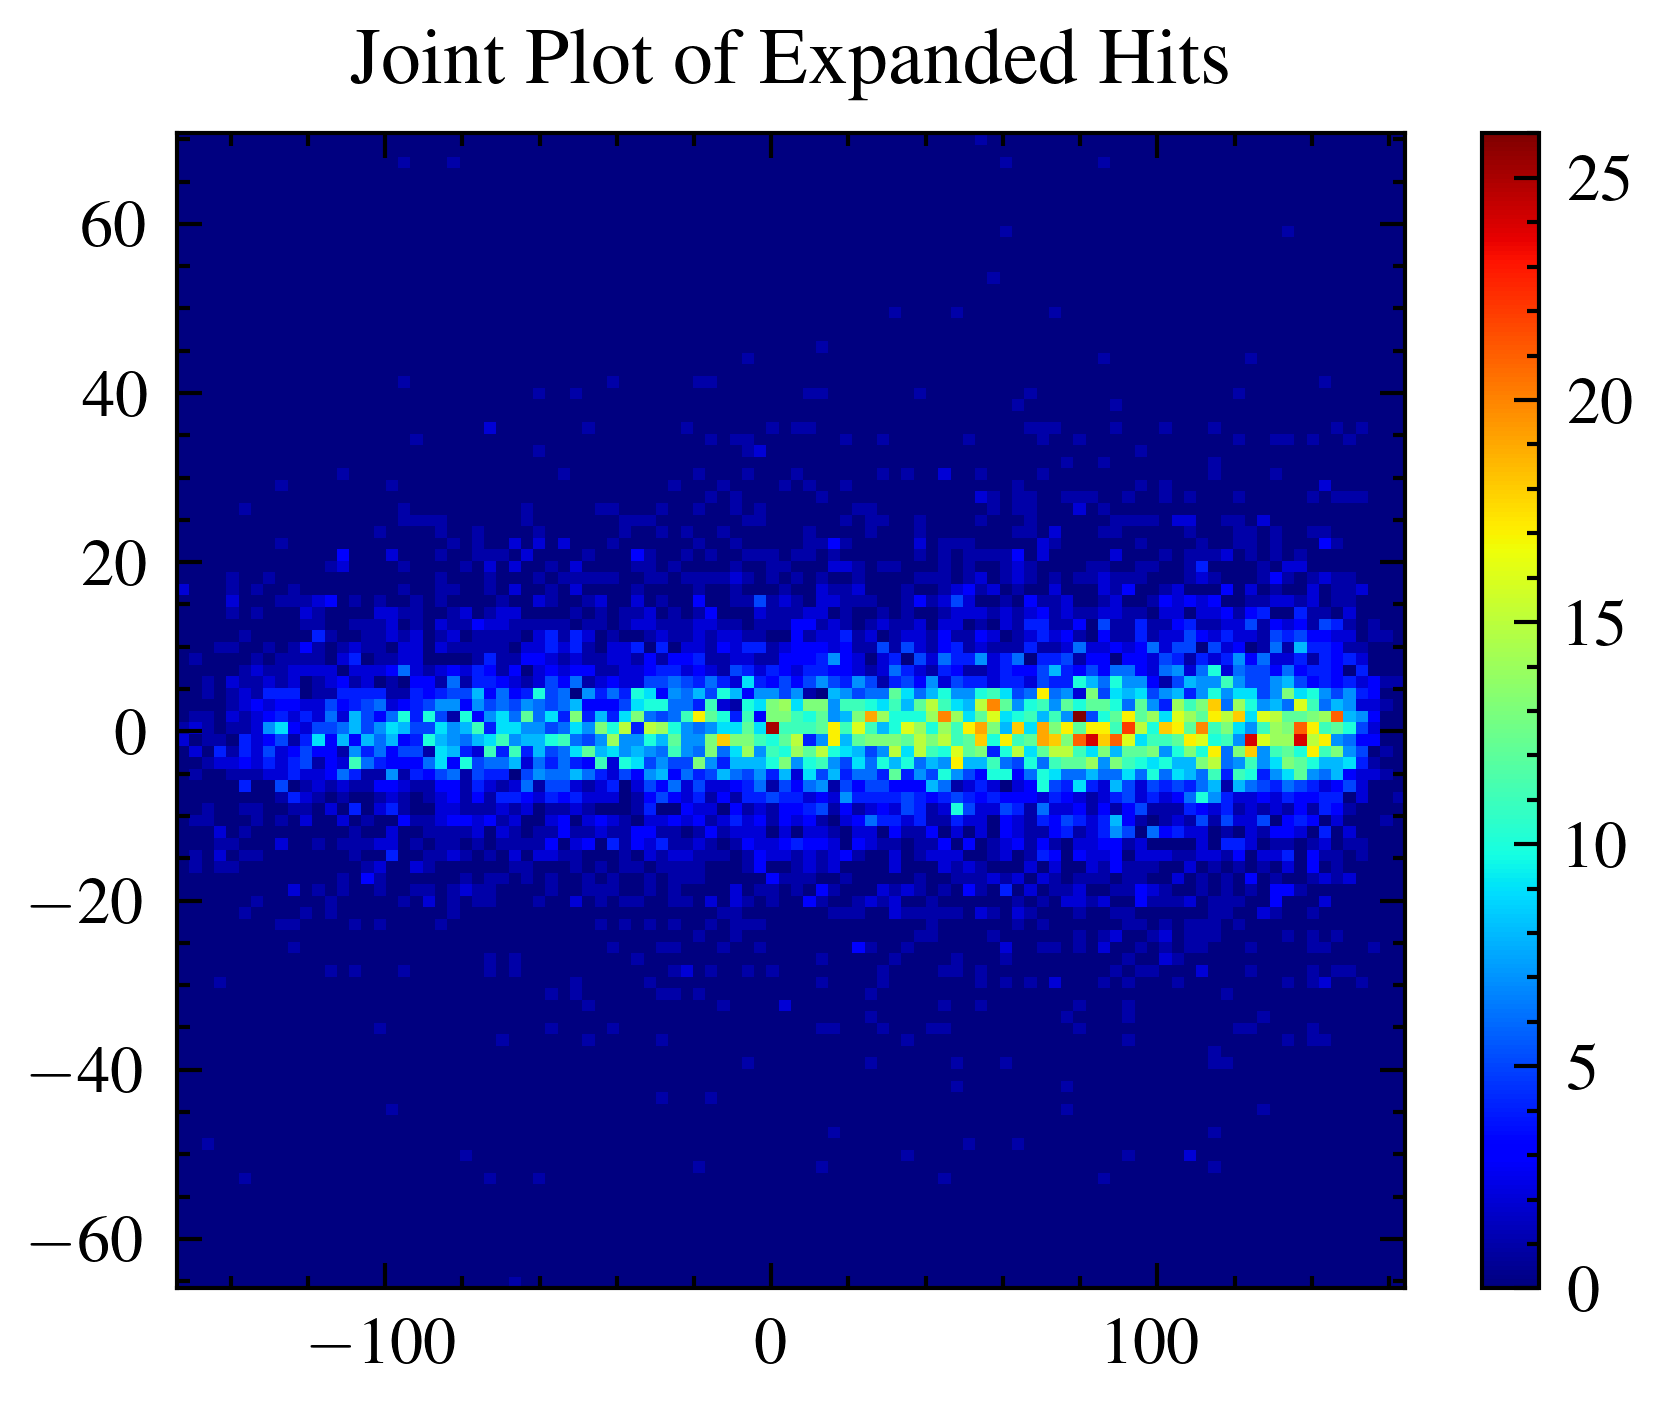

In [7]:
from scipy.stats import gaussian_kde

pointzy=np.column_stack((hits_z, hits_y))
#sns.jointplot(x=hits_z, y=hits_y, kind='kde')
#plt.title('Joint Plot of Hits')
#plt.show()

# Expanding hits_z and hits_y with 1000 times the points they already have
# Smooth the distributions

# Using Kernel Density Estimation (KDE) for smoothing individual distributions
kde_z = gaussian_kde(hits_z, bw_method=0.07)
kde_y = gaussian_kde(hits_y, bw_method=0.01)

kde_z = kde_z.resample(10000)[0]
kde_y = kde_y.resample(10000)[0]


# Plotting the expanded data
plt.hist2d(kde_z, kde_y, bins=(100,100), cmap='jet')
plt.colorbar()
plt.title('Joint Plot of Expanded Hits')
plt.show()



In [8]:
# Define the bin edges
bins = [np.linspace(hits_y.min(), hits_y.max(), 150), np.linspace(hits_z.min(), hits_z.max(), 150)]

# Create a 2D histogram
hist, yedges, xedges = np.histogram2d(hits_y, hits_z, bins=bins)

# Extend each bin in a Gaussian way
ycenters = (yedges[:-1] + yedges[1:]) / 2
xcenters = (xedges[:-1] + xedges[1:]) / 2
y, x = np.meshgrid(ycenters, xcenters)

# Create a Gaussian kernel
sigma = 1.0
gaussian_kernel = np.exp(-((y[:, :, np.newaxis, np.newaxis] - ycenters[np.newaxis, np.newaxis, :, np.newaxis])**2 +
                           (x[:, :, np.newaxis, np.newaxis] - xcenters[np.newaxis, np.newaxis, np.newaxis, :])**2) / (2 * sigma**2))

# Normalize the kernel
gaussian_kernel /= gaussian_kernel.sum(axis=(2, 3))

# Convolve the histogram with the Gaussian kernel
hist_smoothed = np.tensordot(hist, gaussian_kernel, axes=([0, 1], [2, 3]))



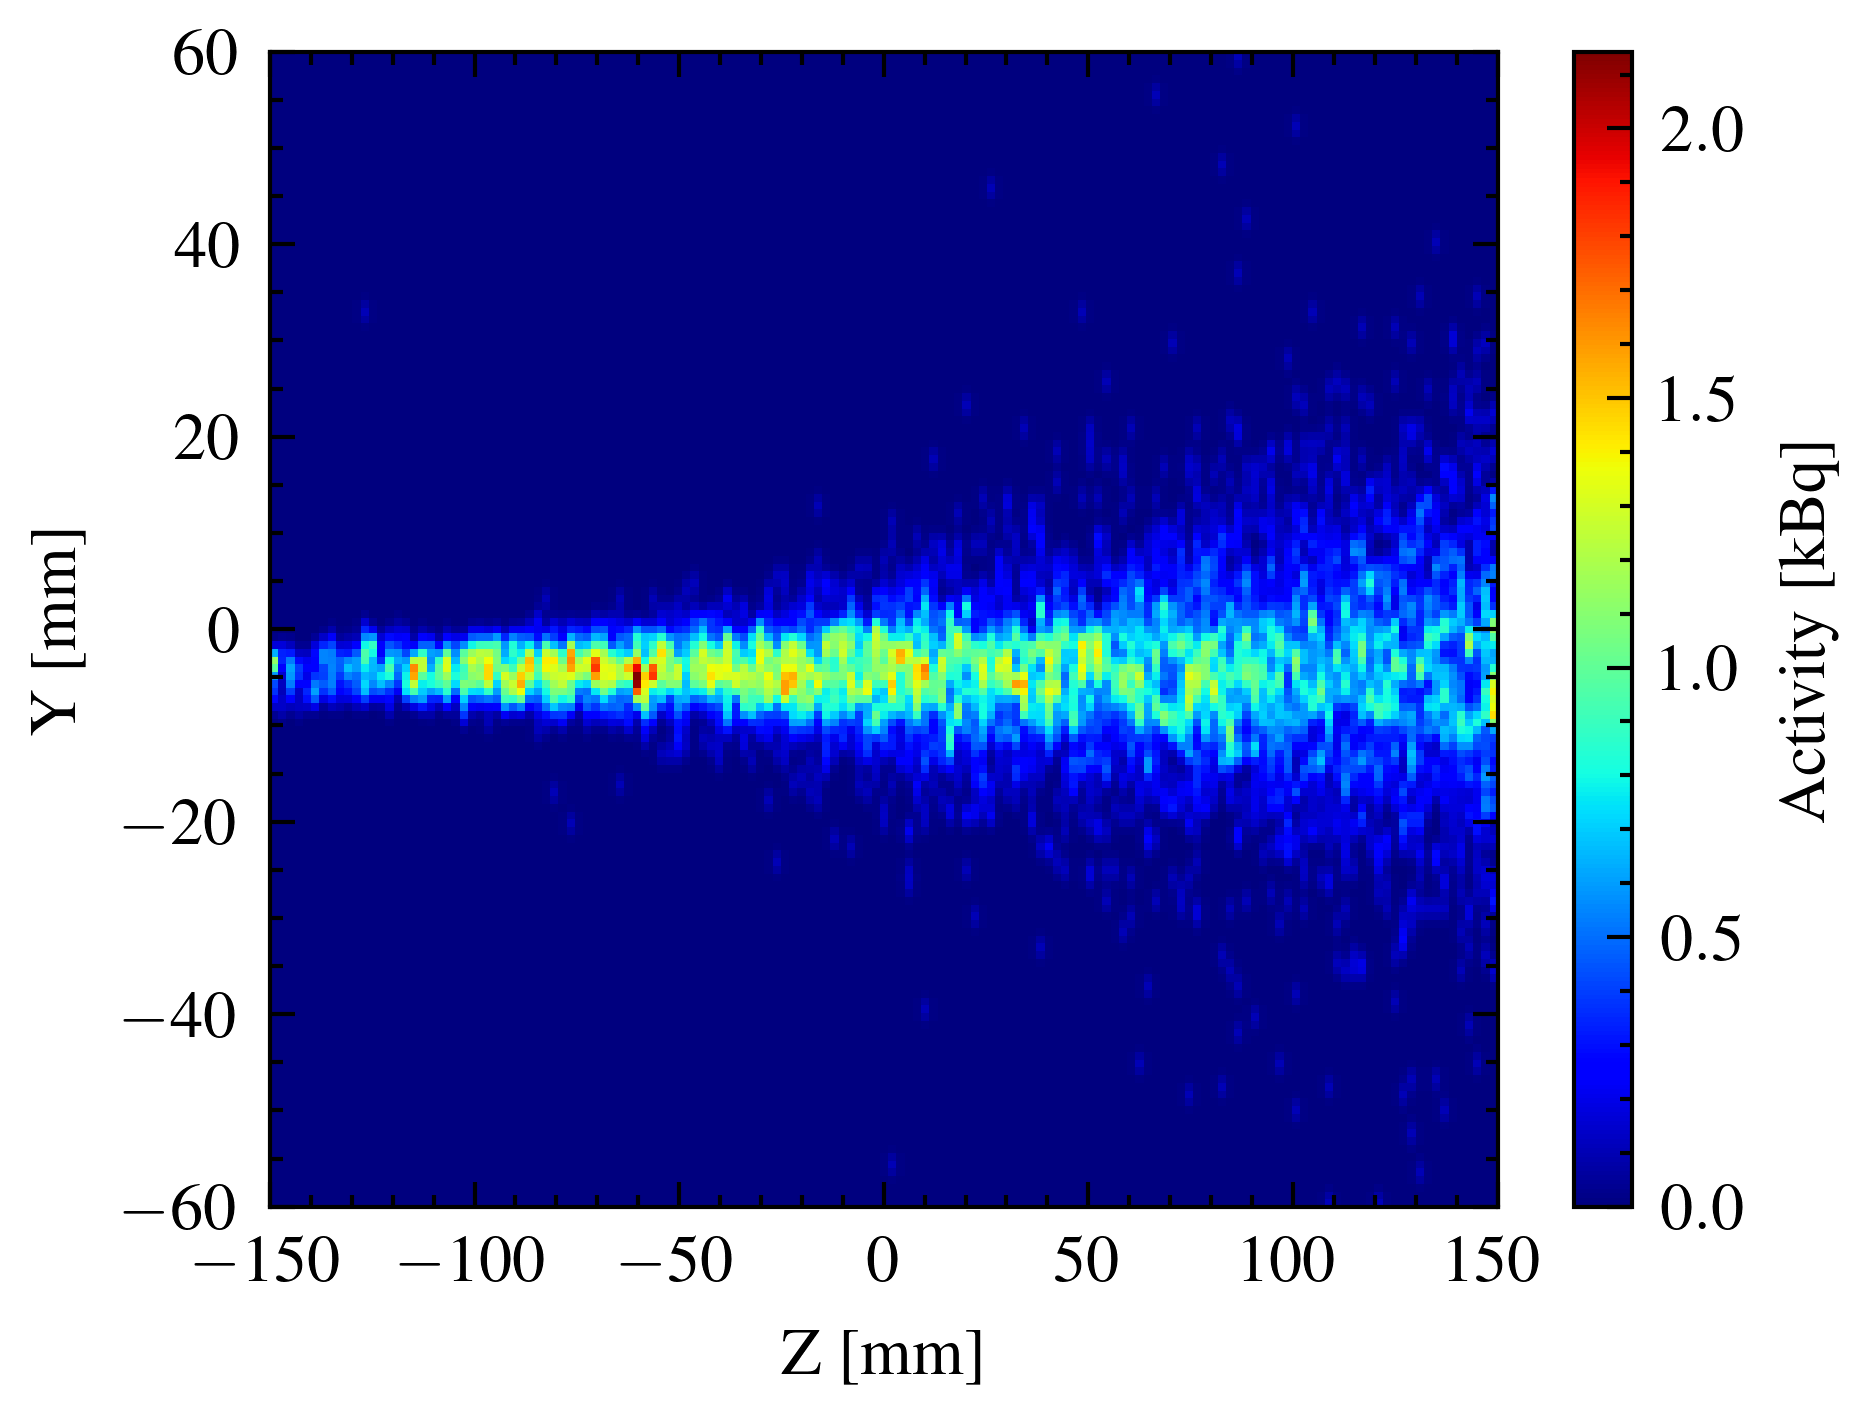

In [15]:
# Plot the smoothed 2D histogram
hist_smoothed1 = (hist_smoothed *0.34) #kBq per 10^11
plt.imshow(hist_smoothed1.T, origin='lower', aspect='auto', cmap='jet', extent=(-150, 150,-60, 60))
plt.colorbar(label='Activity [kBq]')
plt.xlabel('Z [mm]')
plt.ylabel('Y [mm]')
plt.show()

/tmp/ipykernel_5833/2940849493.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


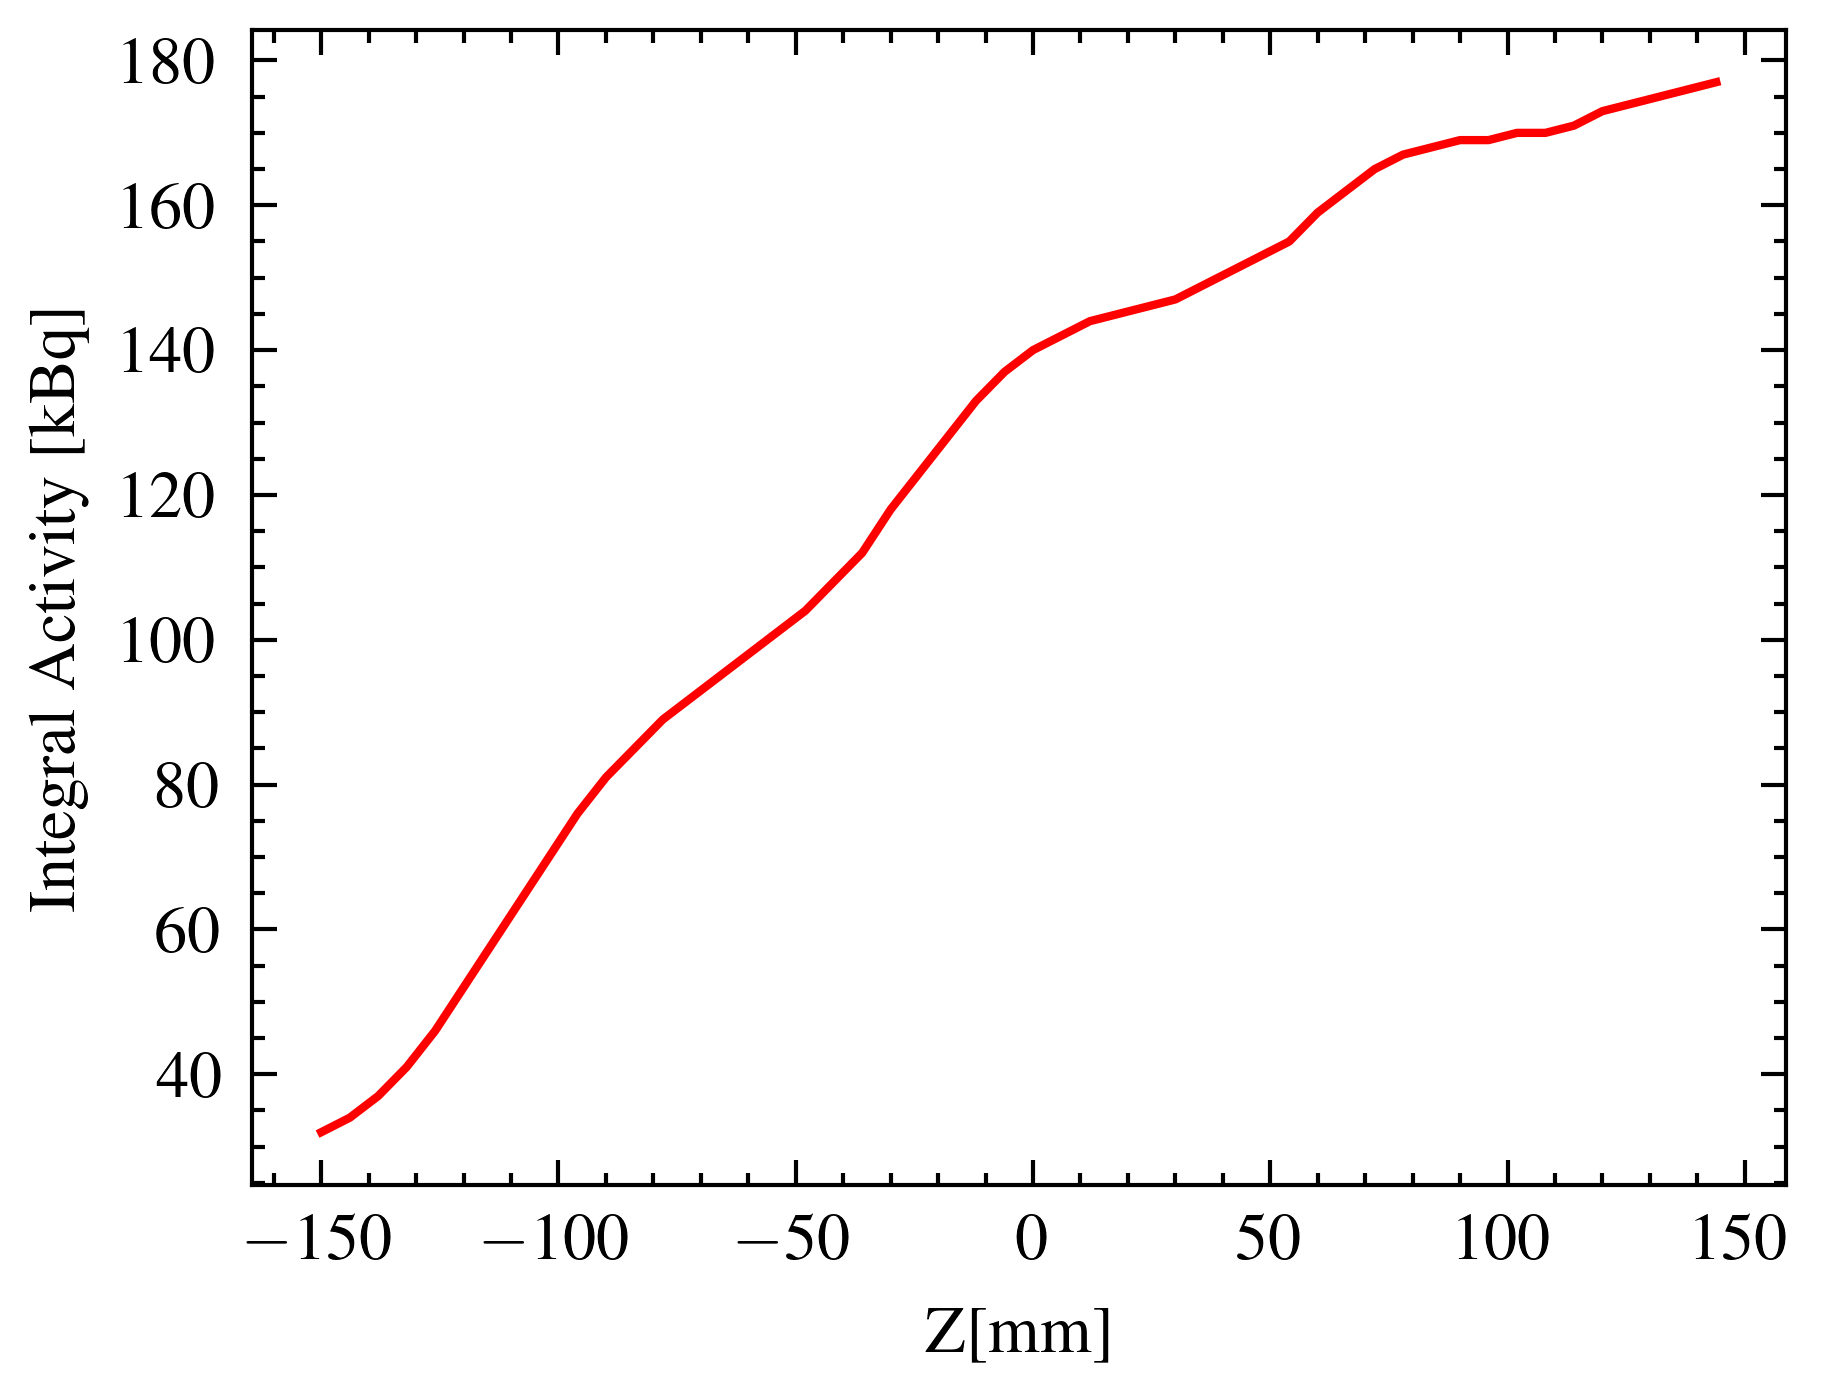

In [16]:
from scipy.ndimage import gaussian_filter1d
hits_z1=hits_z*0.34
# Compute the 1D histogram
hist, bin_edges = np.histogram(hits_z, bins=50)

# Convolve the histogram with a Gaussian filter
hist_smoothed_1d = gaussian_filter1d(hist, sigma=3.0)

# Plot the smoothed histogram
plt.plot(bin_edges[:-1], hist_smoothed_1d, color='red')
plt.xlabel('Z[mm]')
plt.ylabel('Integral Activity [kBq]')
plt.legend()
plt.show()
